In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
DENSE = False
EPS = 120
LAG = 12 + 1
# SROUTE = [
#     '403259-401851', 
#     '401851-401852'
# ]
SROUTE = [
    '400860-400861', 
#     '400861-403781',
#     '400861-400948',
#     '400861-405376',
]
STOPS = len(SROUTE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Full history
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
 [*] Examples (train): 72
 [*] Time range: 2014-08-01 ~ 2014-10-31


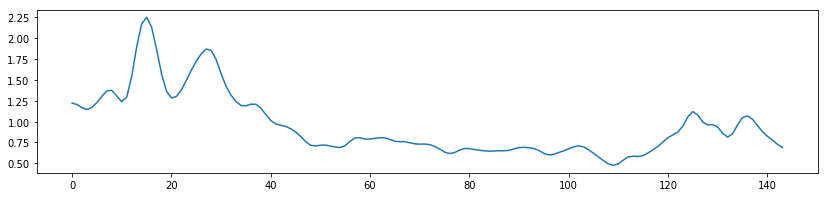

In [14]:
dset = SpotHistory(SROUTE, 'train', 16, lag=None, res=10, smooth=1.5, shuffle=False)

plt.figure(figsize=(14, 3))
for ii in range(len(SROUTE)):
    plt.plot(dset[0][:, ii])
plt.show(); plt.close()

In [5]:
dset = SpotHistory(SROUTE, 'train', 32, lag=LAG, res=10).generator()
evalset = SpotHistory(SROUTE, 'test', 32, lag=LAG, res=10).generator()

Chunks (lag 13)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
 [*] Examples (train): 11726
 [*] Time range: 2014-08-01 ~ 2014-10-31
Chunks (lag 13)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
 [*] Examples (test): 11726
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [6]:
from models.Linear import *
model = Linear(lag=LAG-1, stops=STOPS).to(device)
model.device = device
criterion, opt, sch = model.params(lr=0.05)

In [8]:
evf = lambda: evaluate(
    evalset, model, 
    crit=lambda _y, y: criterion(_y[:, 0], y[:, 0]).item())
_ = evf()

Eval loss: 202.41234           


In [9]:
losses = []
eval_mse = []
eval_mape = []

for eii  in range(EPS):
    bls = []
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        bls.append(loss.item())
        sys.stdout.write('[%d/%d : %d/%d] - L%.2f %s      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item(),
            '(avg %.2f)' % (10 ** 2 * np.mean(bls)) if bii == len(dset) -1 else ''
        ))
    sys.stdout.write('\n')

    eval_mse.append(evf())
    sys.stdout.flush()
    sch.step()

[1/120 : 367/367] - L0.68 (avg 2.35)      
Eval loss: 0.95002           
[2/120 : 367/367] - L1.31 (avg 0.78)      
Eval loss: 1.01882           
[3/120 : 367/367] - L0.16 (avg 0.55)      
Eval loss: 0.44762           
[4/120 : 367/367] - L0.22 (avg 0.46)      
Eval loss: 0.39892           
[5/120 : 367/367] - L0.17 (avg 0.41)      
Eval loss: 0.38124           
[6/120 : 367/367] - L0.26 (avg 0.37)      
Eval loss: 0.33932           
[7/120 : 367/367] - L0.56 (avg 0.34)      
Eval loss: 0.53101           
[8/120 : 367/367] - L0.26 (avg 0.33)      
Eval loss: 0.42884           
[9/120 : 367/367] - L0.28 (avg 0.31)      
Eval loss: 0.27776           
[10/120 : 367/367] - L0.59 (avg 0.29)      
Eval loss: 0.30423           
[11/120 : 367/367] - L0.07 (avg 0.28)      
Eval loss: 0.24825           
[12/120 : 367/367] - L0.08 (avg 0.27)      
Eval loss: 0.24043           
[13/120 : 367/367] - L0.05 (avg 0.25)      
Eval loss: 0.22984           
[14/120 : 367/367] - L0.20 (avg 0.25)      
Eva

Eval loss: 0.11623           
[112/120 : 367/367] - L0.04 (avg 0.12)      
Eval loss: 0.11659           
[113/120 : 367/367] - L0.13 (avg 0.12)      
Eval loss: 0.11576           
[114/120 : 367/367] - L0.06 (avg 0.12)      
Eval loss: 0.11589           
[115/120 : 367/367] - L0.36 (avg 0.12)      
Eval loss: 0.11548           
[116/120 : 367/367] - L0.04 (avg 0.12)      
Eval loss: 0.11535           
[117/120 : 367/367] - L0.04 (avg 0.12)      
Eval loss: 0.11549           
[118/120 : 367/367] - L0.20 (avg 0.12)      
Eval loss: 0.11512           
[119/120 : 367/367] - L0.04 (avg 0.12)      
Eval loss: 0.11483           
[120/120 : 367/367] - L0.07 (avg 0.12)      
Eval loss: 0.11505           


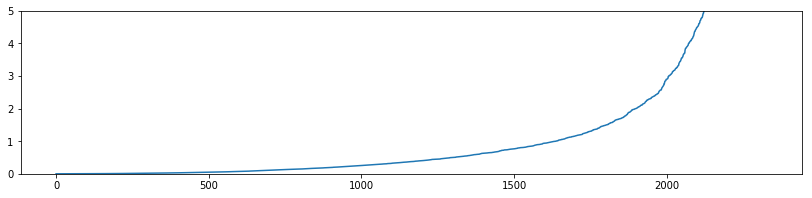

In [11]:
plt.figure(figsize=(14, 3))
plt.plot(sorted(sqerr)); plt.ylim(0, 5)
plt.show(); plt.close()

In [29]:
from utils import *
viewset = SpotHistory(SROUTE, 'test', 18, lag=None, res=10, shuffle=False, verbose=False)
mses = []

sqerr = eval_lin(viewset, model, test_lag=LAG-1, fmax=10, plot=False)
print('Eval segments:', len(viewset))
print('Eval MSE: %.4f' % np.mean(sqerr))

Eval segments: 18
Eval MSE: 0.1448


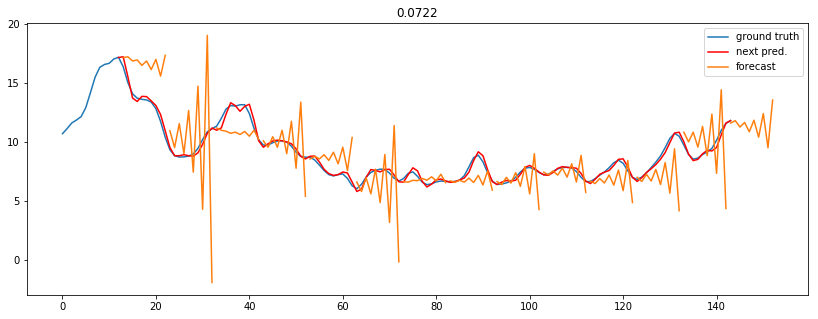

In [32]:
_ = eval_lin(viewset[:1], model, test_lag=LAG-1, fmax=10, plot=True)